In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

## 3D meshing example

This notebook shows how to

1. Load and visualize a volume
1. Apply image filters to and segment image
1. Generate a 3D surface mesh from the binary image
1. Decimate/simplify a 3D mesh
1. Visualize and save the mesh to gmsh22 format

### Todo:

- Generate 3D volume mesh
- Surface mesh must be 'watertight'
- Constrained Delaunay triangulation to fix surface (do not go outside surface), i.e.
https://notebook.community/daniel-koehn/Theory-of-seismic-waves-II/02_Mesh_generation/4_Tri_mesh_delaunay_yigma_tepe,
https://wias-berlin.de/software/tetgen/1.5/doc/manual/manual002.html#sec7

In [3]:
from nanomesh.volume import Volume
import pyvista as pv
from skimage import filters

In [4]:
vol = Volume.load('sample_data.npy')
vol_gauss = vol.apply(filters.gaussian, sigma=5)
thresh = filters.threshold_li(vol_gauss.image)

seg_vol = Volume(1.0 * (vol_gauss.image >= thresh))
seg_vol.show_slice()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='index', max=199), Dropdown(description='along', options=…

### Generate 3d tetragonal mesh

In [6]:
import numpy as np

def simplify_mesh_trimesh(vertices, faces, n_faces):
    """Simplify mesh using trimesh."""
    import trimesh
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)
    decimated = mesh.simplify_quadratic_decimation(n_faces)
    return decimated

def simplify_mesh_open3d(vertices: np.ndarray, faces: np.ndarray, n_faces):
    """Simplify mesh using open3d."""
    import open3d
    o3d_verts = open3d.utility.Vector3dVector(vertices)
    o3d_faces = open3d.utility.Vector3iVector(faces)
    o3d_mesh = open3d.geometry.TriangleMesh(o3d_verts, o3d_faces)

    o3d_new_mesh = o3d_mesh.simplify_quadric_decimation(n_faces)
    
    new_verts = np.array(o3d_new_mesh.vertices)
    new_faces = np.array(o3d_new_mesh.triangles)
    
    decimated = meshio.Mesh(points=new_verts, cells=[('triangle', new_faces)])
    return decimated

In [11]:
from skimage import measure
from scipy.spatial import Delaunay

image = seg_vol.image

point_density = False
pad = False

plot = False

if point_density:
    # grid_points = add_points_grid(image, border=5)
    n_points1 = int(np.sum(image == 1) * point_density)
    grid_points = add_points_kmeans(image, iters=20, n_points=n_points1)
    points.append(grid_points)

    # adding points to holes helps to get a cleaner result
    n_points0 = int(np.sum(image == 0) * point_density)
    grid_points = add_points_kmeans(1 - image,
                                    iters=20,
                                    n_points=n_points0)
    points.append(grid_points)

if pad:
    n_points_edge = (np.array(image.shape) *
                     (point_density**0.5)).astype(int)
    pad_points = add_edge_points(image, n_points=n_points_edge)
    points.append(pad_points)
    # image = np.pad(image, 1, constant_values=0)


# vers = contours
verts, faces, normals, values = measure.marching_cubes(
    image, 
    allow_degenerate=False,
    step_size=5,
)

mesh = simplify_mesh_trimesh(vertices=verts, faces=faces, n_faces=5000)
points = mesh.vertices

d = Delaunay(points, incremental=False)



mask = image[tuple(cell_center.astype(int).T)] == 0
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

plotter = pv.PlotterITK()
plotter.add_mesh(subgrid)
plotter.show()




tri_x, tri_y, tri_z = triangles.T
centers = (points[tri_x] + points[tri_y] + points[tri_z]) / 3
mask = image[tuple(centers.astype(int).T)] == 0

if plot:
    plot_mesh_steps(
        image=image,
        contours=contours,
        points=points,
        triangles=triangles,
        mask=mask,
    )

cells = [
    ('triangle', triangles[~mask]),
]

mesh = meshio.Mesh(points, cells)
mesh.remove_orphaned_nodes()

return mesh

NameError: name 'cell_center' is not defined

In [15]:
mesh

<trimesh.Trimesh(vertices.shape=(2624, 3), faces.shape=(5000, 3))>

In [97]:
d.simplices

(16578, (16578,))

In [91]:
pv.plot_itk(mesh)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### Pad array to create boundary

In [48]:
seg_pad_vol = seg_vol.apply(
    np.pad,                           
    pad_width=1,
    constant_values=0,
)

In [52]:
from skimage import measure

verts, faces, normals, values = measure.marching_cubes(
    seg_pad_vol.image, 
    allow_degenerate=False,
    step_size=1,
)

print(f'verts: {verts.shape[0]}\nfaces: {faces.shape[0]}')

verts: 735211
faces: 1470758


In [53]:
import meshio
mesh = meshio.Mesh(points=verts, cells=[('triangle', faces)])

import pyvista as pv
pv.plot_itk(mesh)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [12]:
import numpy as np


def decimate_mesh(vertices: np.ndarray, faces: np.ndarray, factor):
    import open3d
    o3d_verts = open3d.utility.Vector3dVector(vertices)
    o3d_faces = open3d.utility.Vector3iVector(faces)
    o3d_mesh = open3d.geometry.TriangleMesh(o3d_verts, o3d_faces)

    n_target_triangles = int(len(faces) * factor)
    o3d_new_mesh = o3d_mesh.simplify_quadric_decimation(n_target_triangles)
    
    return np.array(o3d_new_mesh.vertices), np.array(o3d_new_mesh.triangles)

verts_dec, faces_dec = decimate_mesh(verts, faces, 0.01)
decimated_mesh = meshio.Mesh(points=verts_dec, cells=[('triangle', faces_dec)])

In [54]:
decimated_mesh = simplify_mesh_open3d(verts, faces, 5000)

print(decimated_mesh)

import pyvista as pv
pv.plot_itk(decimated_mesh)

<meshio mesh object>
  Number of points: 8715
  Number of cells:
    triangle: 14706


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [84]:
import trimesh
mesh3 = trimesh.Trimesh(vertices=verts, faces=faces)

decimated_mesh3 = mesh3.simplify_quadratic_decimation(11544)

print(decimated_mesh3)

pv.plot_itk(decimated_mesh3)

<trimesh.Trimesh(vertices.shape=(5605, 3), faces.shape=(11544, 3))>


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [15]:
## Crashes
# from quad_mesh_simplify import simplify_mesh

# node_target = 6622
# simplified = simplify_mesh(np.array(mesh3.vertices),
#                        np.array(mesh3.faces, dtype=np.uint32),
#                        node_target)
# decimated = trimesh.Trimesh(vertices=simplified[0], faces=simplified[1])

# print(decimated)

# pv.plot_itk(decimated)

## 

### Generating volumetric / tetragonal mesh

In [56]:
from scipy.spatial import Delaunay

d = Delaunay(decimated_mesh3.vertices)
d.simplices

import meshio
cells = [
    ('tetra', d.simplices),
]
vmesh = meshio.Mesh(decimated_mesh3.vertices, cells)

pv.plot_itk(vmesh)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [98]:
pv.PolyData?

In [99]:
import vtk

In [ ]:
pv.PolyData(var_inp=verts, faces=faces)

In [70]:
pvmesh = pv.from_meshio(vmesh)
vmesh

<meshio mesh object>
  Number of points: 5605
  Number of cells:
    tetra: 38097

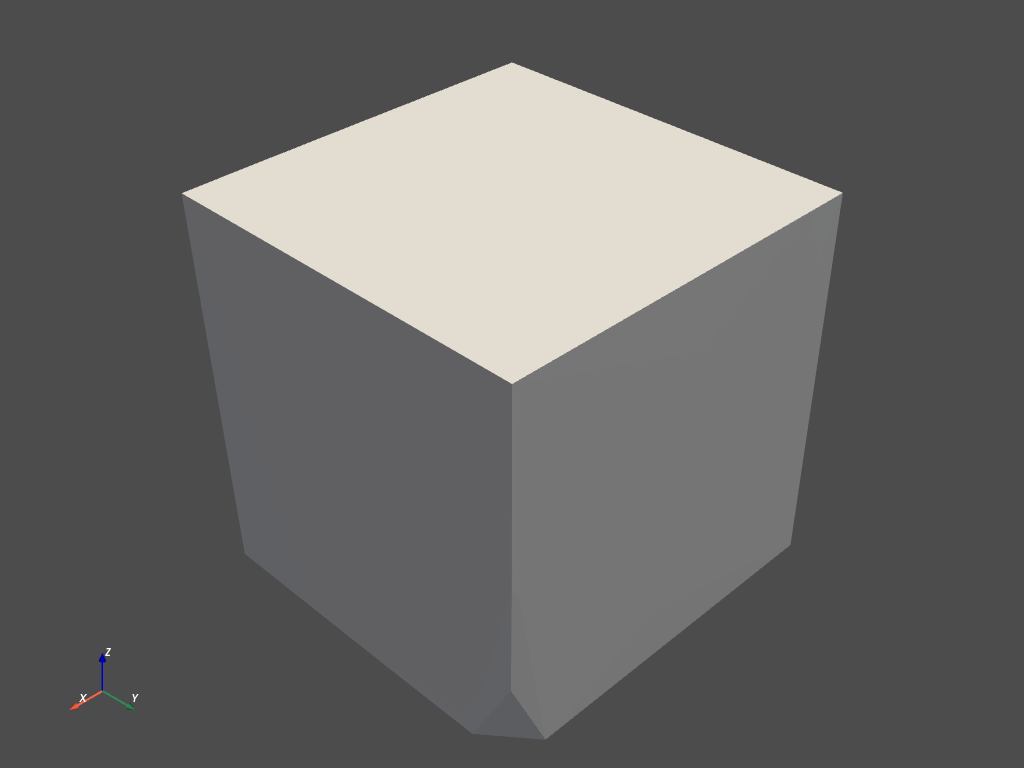

[(487.24019959740156, 487.201357134477, 487.2410365080607),
 (100.49418433648289, 100.45534187355835, 100.49502124714203),
 (0.0, 0.0, 1.0)]

In [78]:
pvmesh.plot()

In [58]:
grid = pvmesh

# get cell centroids
cells = grid.cells.reshape(-1, 5)[:, 1:]
cell_center = grid.points[cells].mean(1)

# extract cells below the 0 xy plane
mask = cell_center[:, 2] < 100
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

# advanced plotting
plotter = pv.PlotterITK()
plotter.add_mesh(subgrid, 'lightgrey')
# plotter.add_mesh(pvmesh, 'r', 'wireframe')
# plotter.add_legend([[' Input Mesh ', 'r'],
#                     [' Tesselated Mesh ', 'black']])
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [69]:
mask = seg_pad_vol.image[tuple(cell_center.astype(int).T)] == 0
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

plotter = pv.PlotterITK()
plotter.add_mesh(subgrid)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…